In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%reload_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm
import logging
import random

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
%%capture
!pip3 install -e gym-go

In [5]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [6]:
BOARD_SIZE = 7

# Machine Learning Models
Actor-Critic method

In [7]:
from tensorflow.keras import layers

In [8]:
def make_actor_critic(mode):
    assert mode == 'actor' or mode == 'critic'
    
    inputs = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 4), name="board")
    valid_inputs = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE), name="valid_board_moves")
    
    # Dense block
    num_layers = 5
    growth_rate = 4
    x = inputs
    for i in range(num_layers):
        y = tf.keras.Sequential([
            layers.Conv2D(filters=4, kernel_size=5, padding="same", bias_initializer='ones'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ], name='dense_layer_{}'.format(i))(x)
        x = layers.Concatenate()([x,y])
    
    board_distr = layers.Conv2D(filters=1, kernel_size=5, padding="same",
                                name="board_distr")(x)
    if mode == 'actor':
        board_distr = layers.Flatten(name='board_distr_1d')(board_distr)
        board_distr = layers.Softmax(name='board_distr_softmax')(board_distr)
            
    board_distr = layers.Reshape((BOARD_SIZE, BOARD_SIZE), name="board_distr_2d")(board_distr)
    board_distr = layers.Multiply(name="valid_board_distr")([board_distr, valid_inputs])
    
    pass_value = layers.Conv2D(filters=1, kernel_size=BOARD_SIZE, padding="valid",
                              activation="sigmoid" if mode == 'actor' else None, 
                               bias_initializer=tf.keras.initializers.Constant(-10), name="pass_value")(x)
    pass_value = layers.Flatten(name="pass_value_flattened")(pass_value)
    
    model = tf.keras.Model(inputs=[inputs, valid_inputs], outputs=[board_distr, pass_value], name=mode)
    return model

In [9]:
actor = make_actor_critic('actor')

In [10]:
critic = make_actor_critic(mode='critic')

In [11]:
opponent = tf.keras.models.clone_model(actor)
target_critic = tf.keras.models.clone_model(critic)

In [12]:
state = go_env.reset()
start_state = np.copy(state)
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [13]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[[0,1,3]].transpose(1,2,0).astype(np.float), state[2]] if not channels_last else 
                                          [state[:,:,[0,1,3]].astype(np.float), state[:,:,2]], 
                                          ['board', 'invalid'])):
        plt.subplot(1,4,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

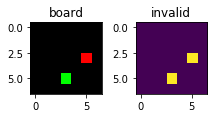

In [14]:
plot_state(state, channels_last=False)

In [15]:
state = state.transpose(1,2,0).reshape(1, BOARD_SIZE, BOARD_SIZE, 4)

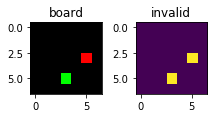

In [16]:
plot_state(state[0], channels_last=True)

### Initialization of models 
should be random if the models are fresh

In [17]:
board_probs, pass_decision = actor([state.astype(np.float32), 1 - state[:,:,:,2].astype(np.float32)])

In [18]:
board_vals, pass_vals = critic([state.astype(np.float32), 1 - state[:,:,:,2].astype(np.float32)])

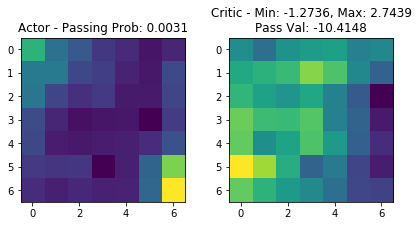

In [19]:
plt.subplot(1,2,1)
plt.title('Actor - Passing Prob: {:.4f}'.format(pass_decision[0][0]))
plt.imshow(board_probs[0])
plt.subplot(1,2,2)
plt.title('Critic - Min: {:.4f}, Max: {:.4f}\nPass Val: {:.4f}'.
          format(tf.math.reduce_min(board_vals[0]), 
                 tf.math.reduce_max(board_vals[0]), 
                 pass_vals[0][0]))
plt.imshow(board_vals[0])
plt.tight_layout()

# Training Setup

### Hyperparameters

In [20]:
NUM_EPISODES = 1000
BATCH_SIZE = 128
MAX_STEPS = 3 * BOARD_SIZE**2
REPLAY_MEM_SIZE = 1024

ACTOR_LEARNING_RATE = 1e-4
OPPONENT_UPDATE = 100 

EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01

CRITIC_LEARNING_RATE = 1e-3
GAMMA = 0.95
TARGET_UPDATE = 1 # number of episodes to update the target critic model

In [21]:
from collections import deque

In [22]:
replay_mem = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [23]:
actor_metrics = {}
for metric_key in ['loss']:
    actor_metrics[metric_key] = tf.keras.metrics.Mean('actor_{}'.format(metric_key), dtype=tf.float32)

critic_metrics = {}
for metric_key in ['loss']:
    critic_metrics[metric_key] = tf.keras.metrics.Mean('critic_{}'.format(metric_key), dtype=tf.float32)

Tensorboard

In [24]:
summary_writers = {}
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
for summary_key in ['main']:
    log_dir = 'logs/actor_critic/{}/{}'.format(current_time, summary_key)
    summary_writers[summary_key] = tf.summary.create_file_writer(log_dir)

In [25]:
import io
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

### Functions

In [26]:
from sklearn import preprocessing
def random_weighted_action(state, pass_prob, board_weights):
    # Decide with 1 / BOARD_SIZE ** 2 chance to pass (pass if we have to)
    if np.random.uniform() < pass_prob or np.isnan(board_weights).any() or np.sum(board_weights) <= 0:
        action = None
    else:
        board_weights_sum = np.sum(board_weights)
        board_weights = tf.reshape(board_weights, (1,BOARD_SIZE**2))
        board_weights = preprocessing.normalize(board_weights, norm='l1')
        board_weights = board_weights.reshape((BOARD_SIZE**2,))
        action_1d = np.random.choice(np.arange(BOARD_SIZE**2), p=board_weights)
        action = (action_1d // BOARD_SIZE, action_1d % BOARD_SIZE)
    return action

In [27]:
def get_action(policy, state, epsilon):
    """
    Gets an action based on exploration/exploitation
    """
    epsilon_choice = np.random.uniform()
    if epsilon_choice < EPSILON:
        # Random move
        logging.debug("Exploring a random move")
        board_weights = 1 - state[2]
        action = random_weighted_action(state, 
                        pass_prob=1/BOARD_SIZE**2, 
                        board_weights=board_weights)
    else:
        # policy makes a move
        logging.debug("Exploiting policy's move")
        if state.shape[0] == 4:
            state = state.transpose(1,2,0)
        reshaped_state = state.reshape(1, BOARD_SIZE, BOARD_SIZE, 4).astype(np.float32)
        act_prob_distr, pass_decision = policy([reshaped_state, 1-reshaped_state[:,:,:,2]])
        
        action = random_weighted_action(state, pass_prob=pass_decision, 
                                        board_weights=act_prob_distr)
        
    return action

In [28]:
def get_value_for_action(board_values, passing_values, actions):
    '''
    Get value from board_values based on action, or take the passing_values if the action is None
    '''
    action_values = tf.gather_nd(board_values, [(i, a[0], a[1]) if a is not None 
                                                    else (i, 0, 0) 
                                                    for i, a in enumerate(actions)])
    action_values = tf.where([a is not None for a in actions], action_values, passing_values)
    return action_values

In [29]:
def get_batch_obs(size=BATCH_SIZE):
    '''
    Get a batch of orig_states, actions, states, rewards, terminals as np array out of replay memory
    '''
    batch = random.sample(replay_mem, size)
    batch = list(zip(*batch))
    orig_states = np.array(list(batch[0]), dtype=np.float32).transpose(0,3,2,1)
    actions = np.array(list(batch[1]))
    states = np.array(list(batch[2]), dtype=np.float32).transpose(0,3,2,1)
    rewards = np.array(list(batch[3]), dtype=np.float32)
    terminals = np.array(list(batch[4]), dtype=np.uint8)
    return orig_states, actions, states, rewards, terminals
    

In [30]:
def max_action_vals(states, actval_func):
    '''
    The maximum action value (including passing) given the states
    '''
    board_val_distrs, passing_vals = actval_func([states, 1-states[:,:,:,2]])
    passing_vals = tf.reshape(passing_vals, (-1,))
    max_board_act_vals = tf.reduce_max(board_val_distrs, axis=[1,2])
    max_vals = tf.math.maximum(max_board_act_vals, passing_vals)
    return max_vals

In [31]:
def calculate_state_vals(states, policy, actval_func):
    '''
    Get the expected value of states
    '''
    board_prob_distrs, passing_probs = policy([states, 1-states[:,:,:,2]])
    board_val_distrs, passing_vals = actval_func([states, 1-states[:,:,:,2]])
    
    passing_probs = tf.reshape(passing_probs, (-1,))
    passing_vals = tf.reshape(passing_vals, (-1,))
    
    # state value is the expected critic value based on the actor's policy
    state_vals = tf.reduce_sum(board_prob_distrs * board_val_distrs, axis=[1,2])
    state_vals = passing_probs * passing_vals + (1 - passing_probs) * state_vals
    return state_vals

In [ ]:
mean_squared_error = tf.keras.losses.MeanSquaredError()

In [32]:
critic_optimizer = tf.keras.optimizers.Adam(CRITIC_LEARNING_RATE)
def update_critic():
    """
    Optimizes the critic in one step and updates the critic loss metric
    """
    states, actions, next_states, rewards, terminals  = get_batch_obs()
    
    # get expected values for next state
    next_state_vals = calculate_state_vals(next_states, actor, target_critic)
    
    with tf.GradientTape() as tape:
        board_val_distrs, passing_vals = critic([states, 1-states[:,:,:,2]])
        passing_vals = tf.reshape(passing_vals, (-1,))
        action_vals = get_value_for_action(board_val_distrs, passing_vals, actions)
        val_loss = mean_squared_error(rewards + GAMMA * next_state_vals * (1-terminals), action_vals)
    
    critic_metrics['loss'](val_loss)
    
    # compute and apply gradients
    gradients = tape.gradient(val_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(gradients, critic.trainable_variables))

In [33]:
actor_optimizer = tf.keras.optimizers.Adam(ACTOR_LEARNING_RATE)
def update_actor():
    """
    Optimizes the actor in one step and updates the critic loss metric
    """
    states, actions, next_states, rewards, terminals = get_batch_obs()
    
    # State values (maximum action values)
    state_vals = max_action_vals(states, critic)
    
    # Next state values (maximum action values of next states)
    next_state_vals = max_action_vals(next_states, critic)
    
    # Advantage values
    avntg_vals = (rewards + GAMMA * next_state_vals * (1-terminals)) - state_vals
    
    with tf.GradientTape() as tape:
        board_prob_distrs, passing_probs = actor([states, 1-states[:,:,:,2]])
        passing_probs = tf.reshape(passing_probs, (-1,))
        action_probs = get_value_for_action(board_prob_distrs, passing_probs, actions)
        avntg_loss = - tf.math.log(action_probs + 1e-6) * avntg_vals
        avntg_loss = tf.math.reduce_mean(avntg_loss)
    
    # log the loss in tensorboard
    actor_metrics['loss'](avntg_loss)
        
    # compute and apply gradients
    gradients = tape.gradient(avntg_loss, actor.trainable_variables)
    actor_optimizer.apply_gradients(zip(gradients, actor.trainable_variables))

In [34]:
def train(episode):
    """
    Plays out a game, and iteratively updates the models at each step
    """
    global EPSILON
    
    # Basic setup
    done = False
    num_of_turns = 0
    state = go_env.reset()
    rewards = []
    
    while not done and num_of_turns <= MAX_STEPS:
        # Copy state for memory
        orig_state = np.copy(state)
        
        action = get_action(actor, state, EPSILON)
        if action is None:
            logging.debug("Black (actor) passed")
            
        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        rewards.append(reward)
        
        # Add to memory
        replay_mem.append((orig_state, action, state, reward, done))
        
        # Update the critic and then actor if we have enough events
        if len(replay_mem) >= BATCH_SIZE:
            update_critic()        
            update_actor()
    
            # Update exploration/exploitation
            if EPSILON > EPSILON_MIN:
                EPSILON *= EPSILON_DECAY
                logging.debug("Epsilon decayed to {}".format(EPSILON))
            
        if done:
            break
            
        # opponent makes a move
        # swap the black and white layers
        temp = np.copy(state[0])
        state[0] = state[1]
        state[1] = temp
        # get action from opponent
        action = get_action(opponent, state, epsilon=0)
        if action is None:
            logging.debug("White (opponent) passed")

        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        rewards.append(reward)
    
    # Game ended
    return num_of_turns, rewards

In [35]:
def heatmap_samples():
    num_samples = 1
    states, _, _, _,_ = get_batch_obs(num_samples)
    states = np.concatenate([states, 
                             start_state.transpose(1,2,0).reshape((-1,BOARD_SIZE, BOARD_SIZE, 4))],
                            axis=0).astype(np.float32)
    board_prob_distrs, pass_probs = actor([states, 1-states[:,:,:,2]])
    board_val_distrs, pass_vals = critic([states, 1-states[:,:,:,2]])
    
    figure = plt.figure(figsize=(8,4))
    for i in range(num_samples + 1):
        plt.subplot(num_samples+1,3,3*i+1+0)
        plt.axis('off')
        plt.title('Board')
        plt.imshow(states[i][:,:,[0,1,3]].astype(np.float))
        plt.subplot(num_samples+1,3,3*i+1+1)
        plt.axis('off')
        plt.title('Actor\n{:.2f}L {:.2f}H {:.2f}P'
                  .format(np.min(board_prob_distrs[i]), 
                          np.max(board_prob_distrs[i]),pass_probs[i][0]))
        plt.imshow(board_prob_distrs[i])
        plt.subplot(num_samples+1,3,3*i+1+2)
        plt.axis('off')
        plt.title('Critic\n{:.2f}L {:.2f}H {:.2f}P'
                  .format(np.min(board_val_distrs[i]), 
                          np.max(board_val_distrs[i]), pass_vals[i][0]))
        plt.imshow(board_val_distrs[i])
        
    plt.tight_layout()
    
    return figure

# Train

In [36]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
for episode in tqdm(range(NUM_EPISODES)):
    # Reset all metrics
    for metric in actor_metrics.values():
        metric.reset_states()
    for metric in critic_metrics.values():
        metric.reset_states()
    
    if episode % OPPONENT_UPDATE == 0:
        opponent = tf.keras.models.clone_model(actor)
        logging.info("Updated opponent")
        
    if episode % TARGET_UPDATE == 0:
        target_critic = tf.keras.models.clone_model(critic)

    num_turns, rewards = train(episode)
    
    # Plot samples of states and actor, critic heatmaps
    fig = heatmap_samples()
    
    # log results
    with summary_writers['main'].as_default():
        tf.summary.image("model heat maps", plot_to_image(fig), step=episode)
        
        tf.summary.scalar('last rewards', rewards[-1], step=episode)
        tf.summary.scalar('rewards sum', sum(rewards), step=episode)
        tf.summary.scalar('number of moves', num_turns, step=episode)
        tf.summary.scalar('critic loss', critic_metrics['loss'].result(), step=episode)
        tf.summary.scalar('actor loss', actor_metrics['loss'].result(), step=episode)
        tf.summary.scalar('epsilon', EPSILON, step=episode)
        

  0%|          | 0/1000 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
I0721 10:31:01.864837 4661790144 <ipython-input-37-fd07e7041786>:10] Updated opponent
  6%|▌         | 62/1000 [16:19<4:21:31, 16.73s/it]

In [ ]:
actor.save_weights('tmp/actor.h5')
critic.save_weights('tmp/critic.h5')

# Evaluate

Test against a pretrained AI

In [ ]:
# TODO

Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size='S')

state = go_env.reset()

done = False
while not done:
    go_env.render()
    
    # Actor's move
    action = get_action(actor, state, 0)
    
    state, reward, done, info = go_env.step(action)
    
    go_env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space (`q` to quit)\n")
        if coords == 'q':
            done = True
            break
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, reward, done, info = go_env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)